# Apeworx Setup

In [86]:
from ape import accounts, chain, Contract, networks, project
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

In [87]:
networks.parse_network_choice('ethereum:local:foundry').__enter__()

INFO: Connecting to existing 'anvil' process.


<foundry chain_id=31337>

In [88]:
project_root = Path.cwd().parent

# Initialize Project Compilation
project.contracts
hyperdrive_user = accounts.test_accounts.generate_test_account()

# Give user 1 eth balance
hyperdrive_user.balance += int(1e18)

# Instantiate Contract Instances
base_ERC20 = project.IERC20Mint.at("0x5fbdb2315678afecb367f032d93f642f64180aa3")
hyperdrive = project.IHyperdrive.at("0x9fe46736679d2d9a65f0992f2272de9f3c7fa6e0")

# get current block
current_block = chain.blocks[-1].number
print(current_block)
pool_info = [hyperdrive.getPoolInfo().__dict__]
pool_info[0]["block_number_"] = current_block

def open_longs():
    # with notation avoids passing in sender each time
    with accounts.use_sender(hyperdrive_user):
        # Mint 1 million DAI
        base_ERC20.mint(int(1e24))

        # Approve ERC20 usage by contract
        base_ERC20.approve(hyperdrive, int(1e24))

        pool_info = hyperdrive.getPoolInfo().__dict__

        # Open Long on 10,000 DAI
        tx_receipt = hyperdrive.openLong(int(1e21), int(1e21), hyperdrive_user, False)
        pt_balance = tx_receipt.return_value
        
        print("user input %s DAI" %(int(1e21)))
        print("user received %s PTs" %(pt_balance))
        
        current_block = chain.blocks[-1]
        pool_info["block_number_"] = current_block.number

        return pool_info


for x in range(50):        
    pool_info += [open_longs()]



153
INFO: Confirmed 0x3b2533929844a22d5bc948c5fb1de92763af260d25a4cfb592f98956f169eacf (total fees paid = 101396000000000)
INFO: Confirmed 0x74fe24d97db765d8b6cc1f707b61b4db2fdba4b61bf12c224671518044b7c87a (total fees paid = 92546000000000)
INFO: Confirmed 0x90d935cc73c102de050110a503bc6e3d6cb12a1422294d31eb35b27827fab4b8 (total fees paid = 306750000000000)
user input 1000000000000000000000 DAI
user received 1017367137621817762683 PTs
INFO: Confirmed 0x4d32267970d97d12e1ceececee2f593db017719cef1a7686068202a144af1c67 (total fees paid = 67196000000000)
INFO: Confirmed 0x5205089defb92d594033f46940e51716ed12d9795f411e322f049cf2505edd37 (total fees paid = 58346000000000)
INFO: Confirmed 0x5908d50404e8cf1594323e0297ba5055d9c501fa82031f5c4ceda662312bc6c6 (total fees paid = 272550000000000)
user input 1000000000000000000000 DAI
user received 1016884197074562217215 PTs
INFO: Confirmed 0x746cf61e4dc4b4bdcbc1103f661c3a4a23df5e4d2e8dac2b24d2991d27c1a51b (total fees paid = 67196000000000)
INFO: Con

INFO: Confirmed 0xa6f02e8e7def293358c2ff20ba5713ca8df174787ab492afbb757721079a6f55 (total fees paid = 67196000000000)
INFO: Confirmed 0xd291477d5850e4ff9b1b55fcda9d4f8a7f1123ae043fbe99d7454807ab355b2c (total fees paid = 58346000000000)
INFO: Confirmed 0x2263285d696a99729bbd506855a8cce0897add1689f3962bae3dc088511a8b9f (total fees paid = 272550000000000)
user input 1000000000000000000000 DAI
user received 1008365739191778789131 PTs
INFO: Confirmed 0xa6e1e154a1196bff872eaecd67996495c3ff17f299300d8f90032f87a51a1920 (total fees paid = 67196000000000)
INFO: Confirmed 0x214d223631e7a61f4d9e6ba89f98b5bc95884b3e0721af3ddad25667f37327c2 (total fees paid = 58346000000000)
INFO: Confirmed 0xb37b5d6d6f5f0d0bdc8591a962e84760b0e87ffa6d029bed433d9cfdfe212d59 (total fees paid = 272550000000000)
user input 1000000000000000000000 DAI
user received 1007900494985894393290 PTs
INFO: Confirmed 0x5d0d14a28c8c632de12797c964679e35167a221c6c500ce03482d82be4b95dbb (total fees paid = 67196000000000)
INFO: Confirme

ContractLogicError: Transaction failed.

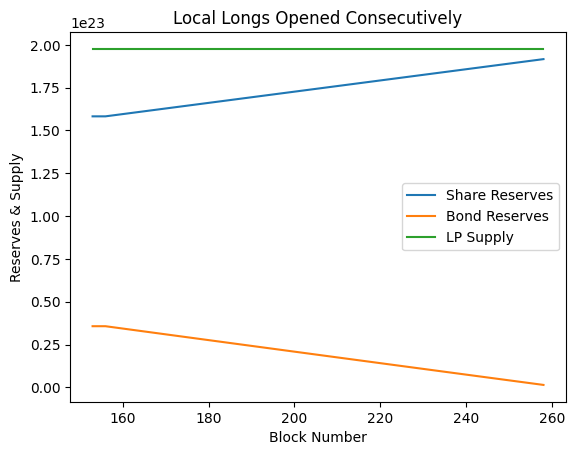

In [89]:
df = pd.DataFrame(pool_info)

plt.figure(1)
plt.plot(df['block_number_'], df['shareReserves_'], label='Share Reserves')
plt.plot(df['block_number_'], df['bondReserves_'], label='Bond Reserves')
plt.plot(df['block_number_'], df['lpTotalSupply'], label='LP Supply')
plt.xlabel('Block Number')
plt.ylabel('Reserves & Supply')
plt.title('Local Longs Opened Consecutively')
plt.legend()
plt.show()
